In [83]:
import numpy as np
import pandas as pd
import sklearn
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report,accuracy_score
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.svm import OneClassSVM
from pylab import rcParams
rcParams['figure.figsize'] = 14, 8
RANDOM_SEED = 42
LABELS = ["Normal", "Fraud"]


In [84]:
data = pd.read_csv('/content/sample_data/creditcard.csv',sep=',')
data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0.0
1,0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0.0
2,1,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0.0
3,1,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0.0
4,2,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0.0


In [85]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23858 entries, 0 to 23857
Data columns (total 31 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Time    23858 non-null  int64  
 1   V1      23858 non-null  float64
 2   V2      23858 non-null  float64
 3   V3      23858 non-null  float64
 4   V4      23858 non-null  float64
 5   V5      23858 non-null  float64
 6   V6      23858 non-null  float64
 7   V7      23858 non-null  float64
 8   V8      23858 non-null  float64
 9   V9      23858 non-null  float64
 10  V10     23858 non-null  float64
 11  V11     23858 non-null  float64
 12  V12     23858 non-null  float64
 13  V13     23858 non-null  float64
 14  V14     23858 non-null  float64
 15  V15     23858 non-null  float64
 16  V16     23858 non-null  float64
 17  V17     23858 non-null  float64
 18  V18     23858 non-null  float64
 19  V19     23858 non-null  float64
 20  V20     23858 non-null  float64
 21  V21     23858 non-null  float64
 22

## Exploratory Data Analysis

In [86]:
data.isnull().values.any()

True

Text(0, 0.5, 'Frequency')

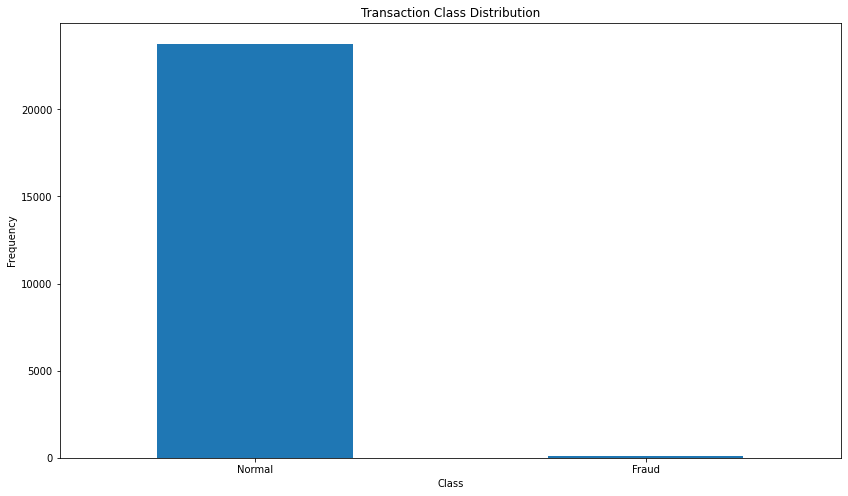

In [87]:
count_classes = pd.value_counts(data['Class'], sort = True)

count_classes.plot(kind = 'bar', rot=0)

plt.title("Transaction Class Distribution")

plt.xticks(range(2), LABELS)

plt.xlabel("Class")

plt.ylabel("Frequency")

In [88]:
## Get the Fraud and the normal dataset 

fraud = data[data['Class']==1]

normal = data[data['Class']==0]

In [89]:
print(fraud.shape,normal.shape)

(88, 31) (23769, 31)


In [90]:
## We need to analyze more amount of information from the transaction data
#How different are the amount of money used in different transaction classes?
fraud.Amount.describe()

count      88.000000
mean      100.010000
std       265.845031
min         0.000000
25%         1.000000
50%         1.000000
75%        99.990000
max      1809.680000
Name: Amount, dtype: float64

In [91]:
normal.Amount.describe()

count    23769.000000
mean        73.880199
std        212.541174
min          0.000000
25%          6.000000
50%         18.110000
75%         65.850000
max       7879.420000
Name: Amount, dtype: float64

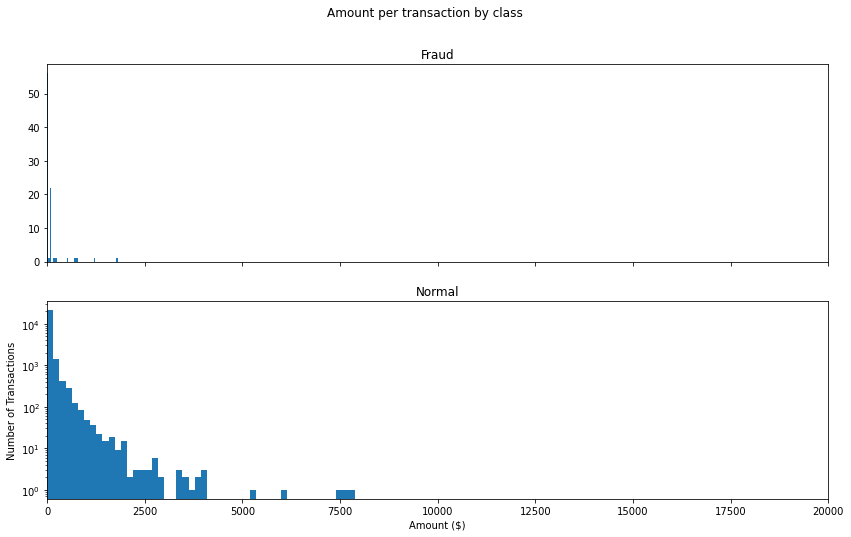

In [92]:
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
f.suptitle('Amount per transaction by class')
bins = 50
ax1.hist(fraud.Amount, bins = bins)
ax1.set_title('Fraud')
ax2.hist(normal.Amount, bins = bins)
ax2.set_title('Normal')
plt.xlabel('Amount ($)')
plt.ylabel('Number of Transactions')
plt.xlim((0, 20000))
plt.yscale('log')
plt.show();

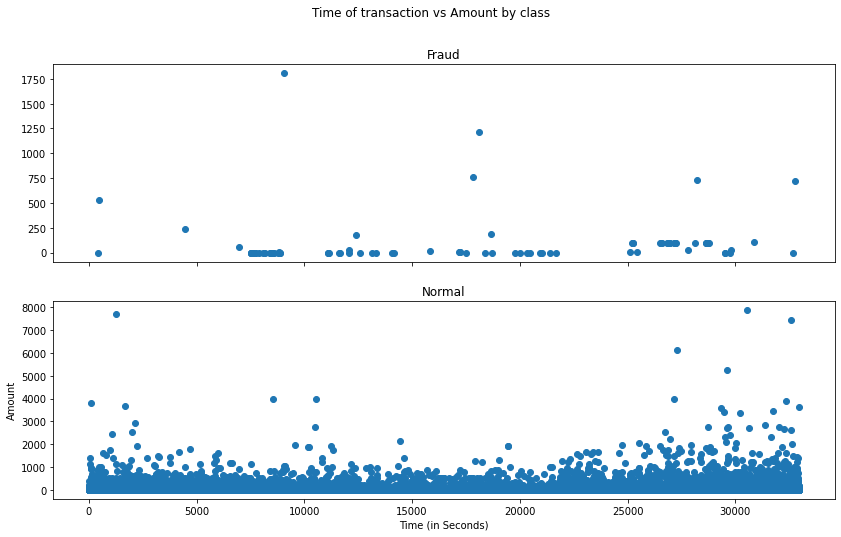

In [93]:
# We Will check Do fraudulent transactions occur more often during certain time frame ? Let us find out with a visual representation.

f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
f.suptitle('Time of transaction vs Amount by class')
ax1.scatter(fraud.Time, fraud.Amount)
ax1.set_title('Fraud')
ax2.scatter(normal.Time, normal.Amount)
ax2.set_title('Normal')
plt.xlabel('Time (in Seconds)')
plt.ylabel('Amount')
plt.show()

In [94]:
## Take some sample of the data

data1= data.sample(frac = 0.1,random_state=1)

data1.shape

(2386, 31)

In [95]:
data.shape

(23858, 31)

In [96]:
#Determine the number of fraud and valid transactions in the dataset

Fraud = data1[data1['Class']==1]

Valid = data1[data1['Class']==0]

outlier_fraction = len(Fraud)/float(len(Valid))

In [97]:
print(outlier_fraction)

print("Fraud Cases : {}".format(len(Fraud)))

print("Valid Cases : {}".format(len(Valid)))

0.00336417157275021
Fraud Cases : 8
Valid Cases : 2378


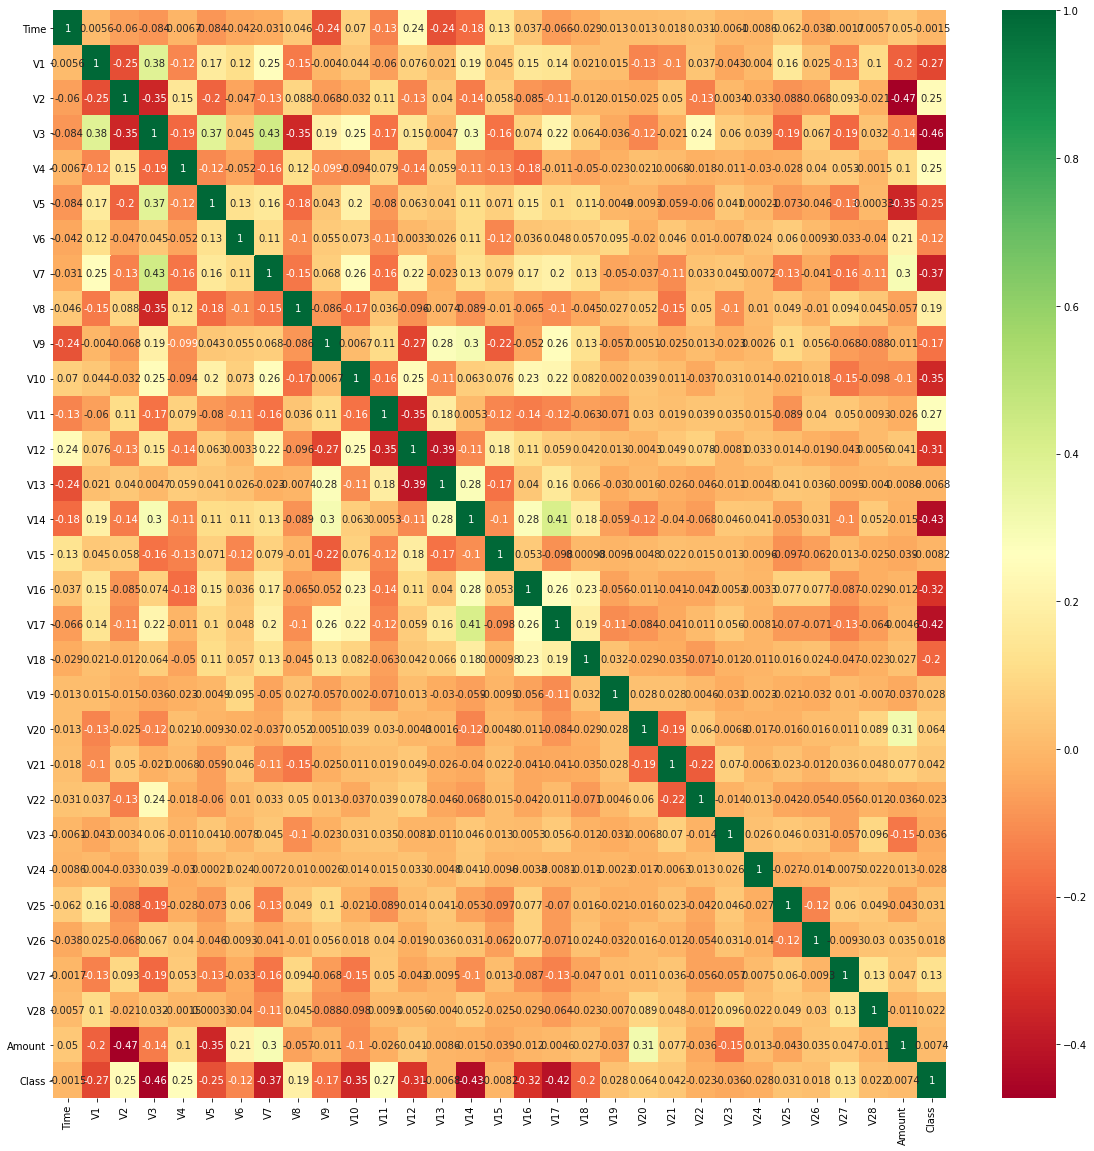

In [98]:
## Correlation
import seaborn as sns
#get correlations of each features in dataset
corrmat = data1.corr()
top_corr_features = corrmat.index
plt.figure(figsize=(20,20))
#plot heat map
g=sns.heatmap(data[top_corr_features].corr(),annot=True,cmap="RdYlGn")

In [99]:
#Create independent and Dependent Features
columns = data1.columns.tolist()

# Filter the columns to remove data we do not want 
columns = [c for c in columns if c not in ["Class"]]
# Store the variable we are predicting 
target = "Class"
# Define a random state 
state = np.random.RandomState(42)

X = data1[columns]
Y = data1[target]

X_outliers = state.uniform(low=0, high=1, size=(X.shape[0], X.shape[1]))
print(X.shape)
print(Y.shape)

(2386, 30)
(2386,)


## Model Prediction





Now it is time to start building the model .The types of algorithms we are going to use to try to do anomaly detection on this dataset are as follows

### Isolation Forest Algorithm :
One of the newest techniques to detect anomalies is called Isolation Forests. The algorithm is based on the fact that anomalies are data points that are few and different. As a result of these properties, anomalies are susceptible to a mechanism called isolation.

### Local Outlier Factor(LOF) Algorithm
The LOF algorithm is an unsupervised outlier detection method which computes the local density deviation of a given data point with respect to its neighbors. It considers as outlier samples that have a substantially lower density than their neighbors.

In [100]:

classifiers = {
    "Isolation Forest":IsolationForest(n_estimators=100, max_samples=len(X), 
                                       contamination=outlier_fraction,random_state=5, verbose=0),
    "Local Outlier Factor":LocalOutlierFactor(n_neighbors=20, algorithm='auto', 
                                              leaf_size=30, metric='minkowski',
                                              p=2, metric_params=None, contamination=outlier_fraction),
    "Support Vector Machine":OneClassSVM(kernel='rbf', degree=3, gamma=0.1,nu=0.05, 
                                         max_iter=-1)
   
}

In [101]:
type(classifiers)

dict

In [102]:
n_outliers = len(Fraud)
for i, (clf_name,clf) in enumerate(classifiers.items()):
    #Fit the data and tag outliers
    if clf_name == "Local Outlier Factor":
        y_pred = clf.fit_predict(X)
        scores_prediction = clf.negative_outlier_factor_
    elif clf_name == "Support Vector Machine":
        clf.fit(X)
        y_pred = clf.predict(X)
    else:    
        clf.fit(X)
        scores_prediction = clf.decision_function(X)
        y_pred = clf.predict(X)
    #Reshape the prediction values to 0 for Valid transactions , 1 for Fraud transactions
    y_pred[y_pred == 1] = 0
    y_pred[y_pred == -1] = 1
    n_errors = (y_pred != Y).sum()
    # Run Classification Metrics
    print("{}: {}".format(clf_name,n_errors))
    print("Accuracy Score :")
    print(accuracy_score(Y,y_pred))
    print("Classification Report :")
    print(classification_report(Y,y_pred))

Isolation Forest: 9
Accuracy Score :
0.9962279966471081
Classification Report :
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      2378
         1.0       0.44      0.50      0.47         8

    accuracy                           1.00      2386
   macro avg       0.72      0.75      0.73      2386
weighted avg       1.00      1.00      1.00      2386

Local Outlier Factor: 17
Accuracy Score :
0.9928751047778709
Classification Report :
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      2378
         1.0       0.00      0.00      0.00         8

    accuracy                           0.99      2386
   macro avg       0.50      0.50      0.50      2386
weighted avg       0.99      0.99      0.99      2386

Support Vector Machine: 1078
Accuracy Score :
0.548197820620285
Classification Report :
              precision    recall  f1-score   support

         0.0       1.00      0.55     